In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc1'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]
num_classes = 10

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

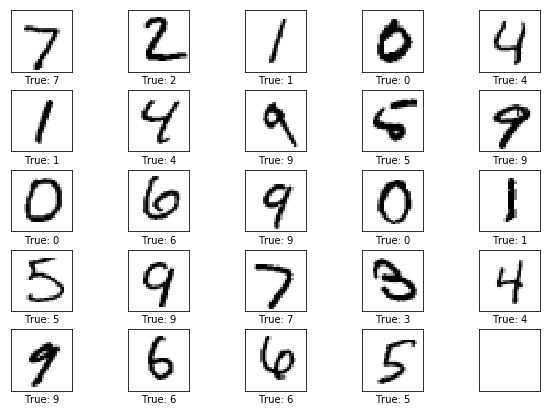

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

## Placeholder variables

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Weights & biases

In [10]:
weights = tf.Variable(tf.truncated_normal([img_size_flat, num_classes], mean=0.0, stddev=0.01))
biases = tf.Variable(tf.truncated_normal([num_classes], mean=0.0, stddev=0.01))

## Model

In [11]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [13]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures

In [14]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create a session

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [16]:
batch_size = 128
def optimize(iterations):
    for i in range(iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict)

## Helper functions to show performance

In [17]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on the test set: {0:.1%}'.format(acc))

def plot_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(num_errors=16):
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

## Helper function to plot the model's weights

In [18]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel('Weights: {0}'.format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

In [19]:
print_accuracy()

Accuracy on the test set: 13.6%


[[  20    6   23  274    0    1   54    2  596    4]
 [   2   52    2 1020    1    0    9    4   45    0]
 [  40   46   27  527    1    8  129    2  237   15]
 [  24   24   17  613    6   12   43    2  269    0]
 [  15   39   13  273    2    3   92    4  534    7]
 [   5    5   33  448    0   13   17    8  356    7]
 [  35   33    3  419    4    2  139    7  306   10]
 [  16   40   29  192    2   86   70    1  581   11]
 [   7   10    8  385    0    3   62    4  491    4]
 [  18    9    6  390    0    4   86    0  496    0]]


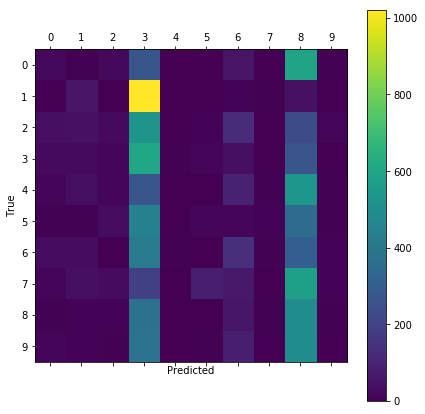

In [20]:
plot_confusion_matrix()

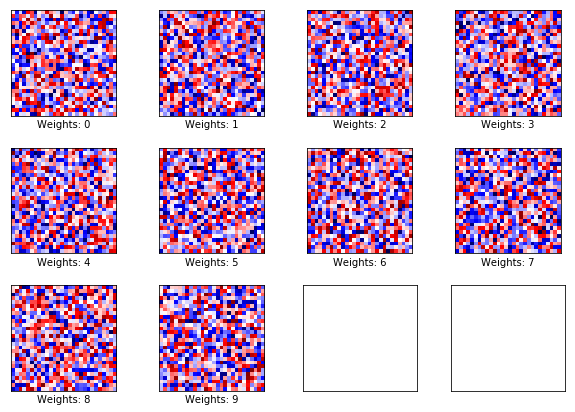

In [21]:
plot_weights()

## Performance after one iteration

In [22]:
optimize(iterations=1)

In [23]:
print_accuracy()

Accuracy on the test set: 14.2%


[[  29    6   19  258    0    1   40    2  623    2]
 [   0   51    1 1015    1    0    8    4   55    0]
 [  44   40   26  520    0    5  109    2  271   15]
 [  25   21   14  621    6    6   32    2  283    0]
 [  14   26   11  258    2    2   79    4  577    9]
 [   6    4   35  434    0    9   14    7  376    7]
 [  38   30    3  401    4    2  143    3  326    8]
 [  17   34   22  181    5   60   67    4  626   12]
 [   7    8    6  359    0    3   50    4  533    4]
 [  18    6    5  372    0    2   75    0  530    1]]


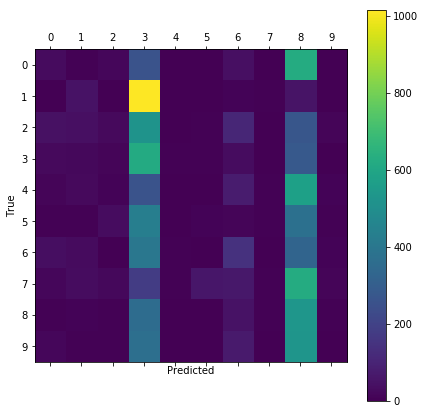

In [24]:
plot_confusion_matrix()

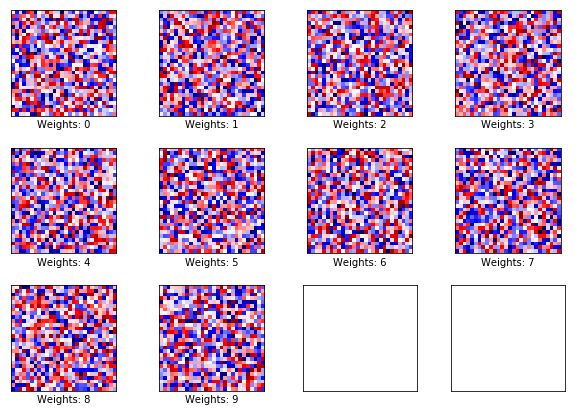

In [25]:
plot_weights()

## Performance after 10 iterations

In [26]:
optimize(iterations=9)

In [27]:
print_accuracy()

Accuracy on the test set: 21.4%


[[284   1   4 219   0   1  24   0 447   0]
 [  0  69   0 973   1   0   2   3  87   0]
 [ 91  20  32 538   0   1  86   1 259   4]
 [ 22   9   3 757   2   2  11   0 204   0]
 [ 31   2   8 234   2   0  89   2 599  15]
 [ 19   2  20 435   0   7   8   5 392   4]
 [ 98   7   4 304   2   0 324   2 212   5]
 [ 17  10  10 199   5  23  24  23 675  42]
 [  5   5   4 297   0   1  23   1 635   3]
 [ 29   1   2 350   0   1  62   3 558   3]]


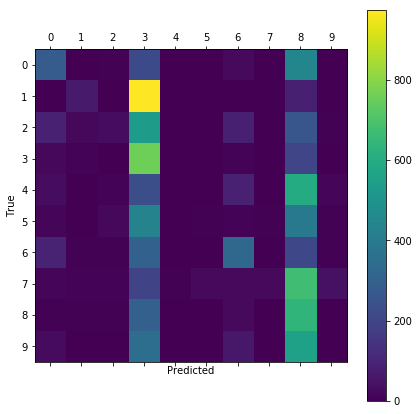

In [28]:
plot_confusion_matrix()

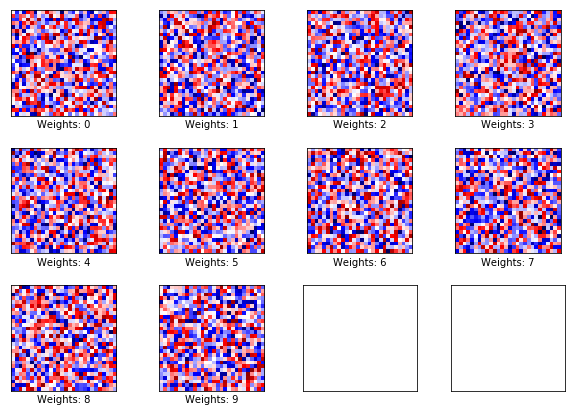

In [29]:
plot_weights()

## Performance after 1000 iterations

In [30]:
optimize(iterations=990)

In [31]:
print_accuracy()

Accuracy on the test set: 85.6%


[[ 923    0    6    6    0    4   27    1   13    0]
 [   0 1068    8    5    1    5    6    0   42    0]
 [  20   21  844   29   18    0   26   19   50    5]
 [   5    8   24  884    1   27    8   18   24   11]
 [   3    9    5    0  835    0   19    2    8  101]
 [  15   14    9  102   23  620   19   10   62   18]
 [  22   18   11    1   12   17  875    0    2    0]
 [   1   36   20    3   14    0    2  883   13   56]
 [  14   31   11   61   13   21   12   16  769   26]
 [  16   15    7   12   48    8    1   35    8  859]]


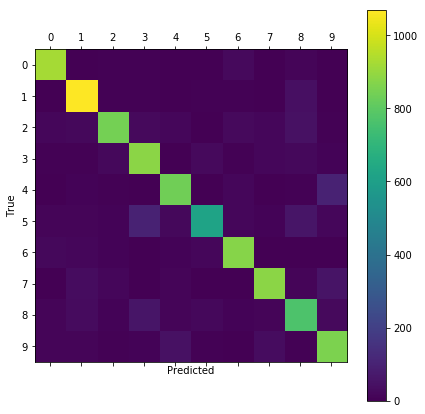

In [32]:
plot_confusion_matrix()

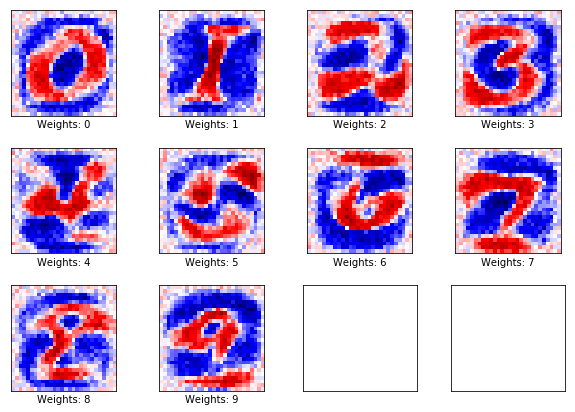

In [33]:
plot_weights()

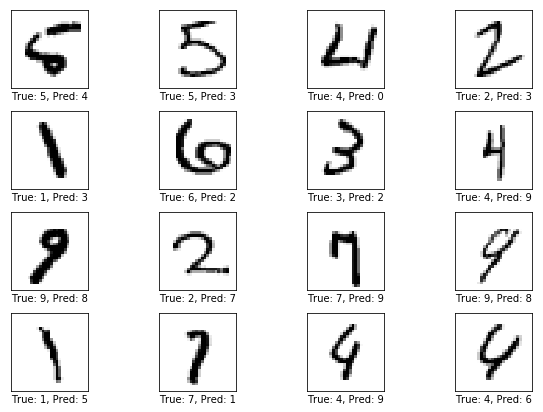

In [34]:
plot_example_errors()

## Performance after 20000 iterations

In [35]:
optimize(iterations=19000)

In [36]:
print_accuracy()

Accuracy on the test set: 92.4%


[[ 959    0    1    1    0    5    9    3    2    0]
 [   0 1111    2    2    0    2    4    2   12    0]
 [   7   10  914   20   11    2   12   10   41    5]
 [   3    0   21  922    0   23    1   10   22    8]
 [   1    1    5    1  920    0   10    2    9   33]
 [   9    2    3   35    9  768   16    7   35    8]
 [  11    3    6    1    8   10  915    2    2    0]
 [   1    7   23    8    6    0    0  944    2   37]
 [   7    6    7   21    9   25   11   12  868    8]
 [  10    7    2   11   29    8    0   20    7  915]]


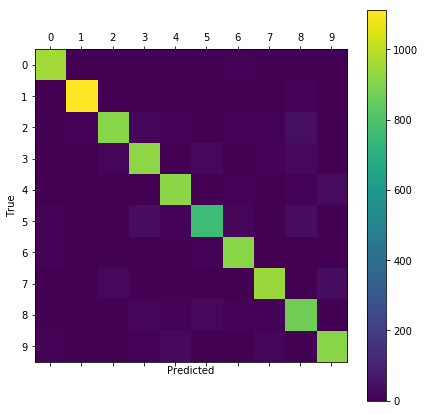

In [37]:
plot_confusion_matrix()

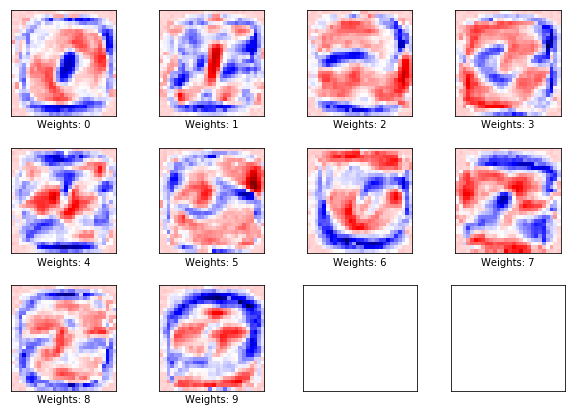

In [38]:
plot_weights()

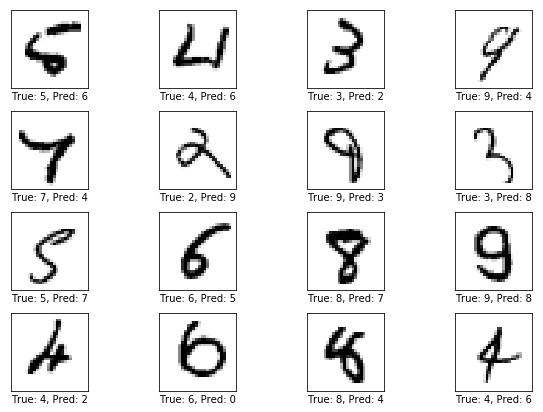

In [39]:
plot_example_errors()

In [40]:
# close TensorFlow Session
session.close()